<a href="https://colab.research.google.com/github/ritwikraha/computer-needs-glasses/blob/master/image-generation/ControlNet_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ControlNet Models



ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) by Lvmin Zhang and Maneesh Agrawala.
It introduces a framework that allows for supporting various spatial contexts that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

Training ControlNet is comprised of the following steps:

1. Cloning the pre-trained parameters of a Diffusion model, such as Stable Diffusion's latent UNet, (referred to as “trainable copy”) while also maintaining the pre-trained parameters separately (”locked copy”). It is done so that the locked parameter copy can preserve the vast knowledge learned from a large dataset, whereas the trainable copy is employed to learn task-specific aspects.
2. The trainable and locked copies of the parameters are connected via “zero convolution” layers (see [here](https://github.com/lllyasviel/ControlNet#controlnet) for more information) which are optimized as a part of the ControlNet framework. This is a training trick to preserve the semantics already learned by frozen model as the new conditions are trained.

Pictorially, training a ControlNet looks like so:

<p align="center">
    <img src="https://github.com/lllyasviel/ControlNet/raw/main/github_page/sd.png" alt="controlnet-structure"><br>
    <em>The diagram is taken from <a href=https://github.com/lllyasviel/ControlNet/blob/main/github_page/sd.png>here</a>.</em>
</p>

A sample from the training set for ControlNet-like training looks like this (additional conditioning is via edge maps):

<table>
<tr style="text-align: center;">
    <th>Prompt</th>
    <th>Original Image</th>
    <th>Conditioning</th>
</tr>
<tr style="text-align: center;">
     <td style="vertical-align: middle">"bird"</td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_bird.png" width=200/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/canny_map.png" width=200/></td>
</tr>
</table>

Similarly, if we were to condition ControlNet with semantic segmentation maps, a training sample would be like so:

<table>
<tr style="text-align: center;">
    <th>Prompt</th>
    <th>Original Image</th>
    <th>Conditioning</th>
</tr>
<tr style="text-align: center;">
    <td style="vertical-align: middle">"big house"</td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_house.png" width=300/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/segmentation_map.png" width=300/></td>
</tr>
</table>

Every new type of conditioning requires training a new copy of ControlNet weights.
The paper proposed 8 different conditioning models that are all [supported](https://huggingface.co/lllyasviel?search=controlnet) in Diffusers!

For inference, both the pre-trained diffusion models weights as well as the trained ControlNet weights are needed. For example, using [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
with a ControlNet checkpoint require roughly 700 million more parameters compared to just using the original Stable Diffusion model, which makes ControlNet a bit more memory-expensive for inference.

Because the pre-trained diffusion models are looked during training, one only needs to switch out the ControlNet parameters when using a different conditioning. This makes it fairly simple
to deploy multiple ControlNet weights in one application as we will see below.

## Setup and Imports

In [1]:
!pip install -q diffusers transformers xformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


In [2]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.25.post1 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.


In [51]:
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import pipeline, AutoImageProcessor, UperNetForSemanticSegmentation
from diffusers import UniPCMultistepScheduler
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from controlnet_aux import OpenposeDetector, HEDdetector

## Utility Functions

In [4]:
def create_canny_image(image):
    image = np.array(image)
    low_threshold = 100
    high_threshold = 200
    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)
    return canny_image

In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [6]:
def delete_pipeline(pipeline):
    pipeline.to("cpu")
    del pipeline
    torch.cuda.empty_cache()

## Canny ControlNet

In [7]:
prompt = "mona lisa, best quality, extremely detailed"

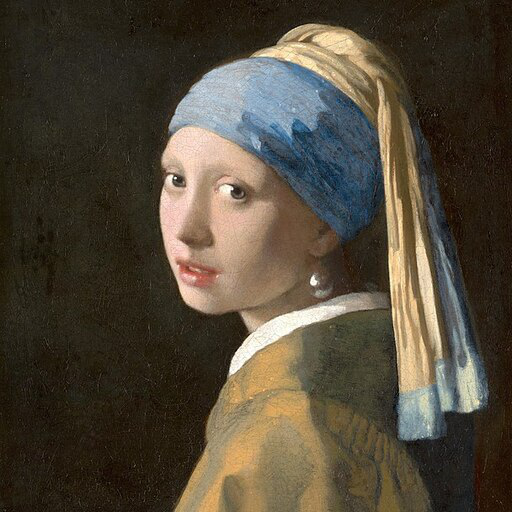

In [8]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

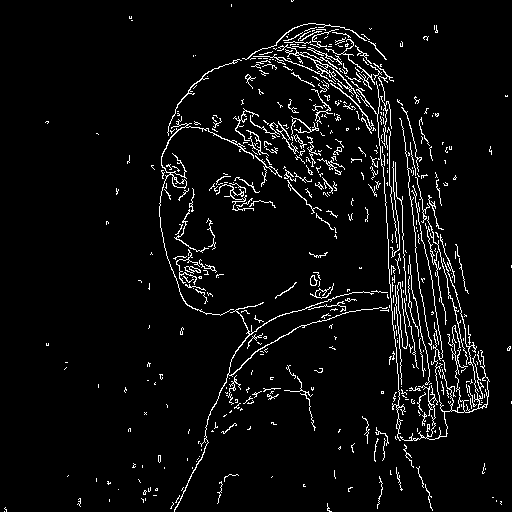

In [9]:
canny_image = create_canny_image(image)
canny_image

In [10]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

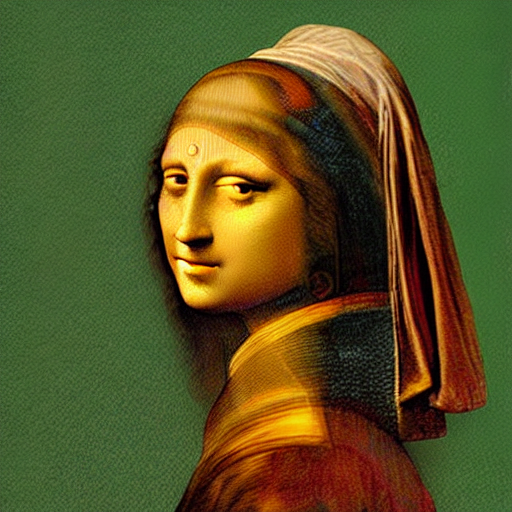

In [11]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, low quality, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=20,
).images[0]

output

In [12]:
delete_pipeline(pipe)

## Pose ControlNet

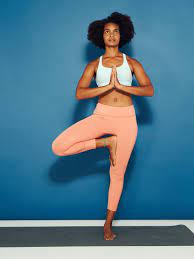

In [13]:
img_pose = load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/yoga1.jpeg")

img_pose

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

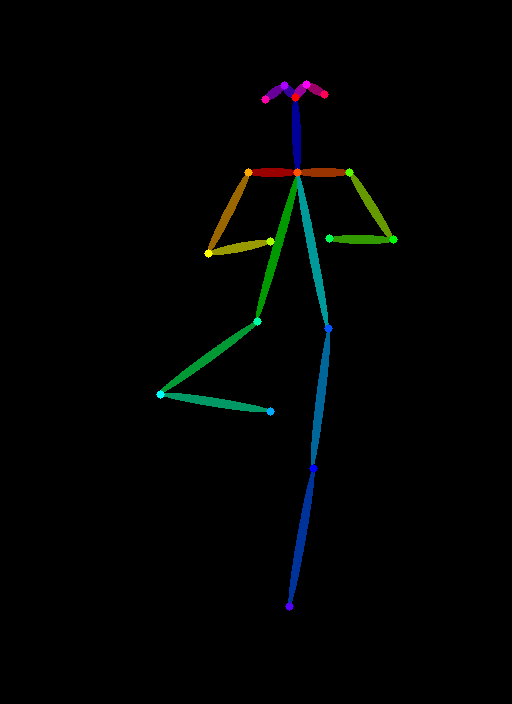

In [14]:
model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

pose = model(img_pose)
pose

In [15]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

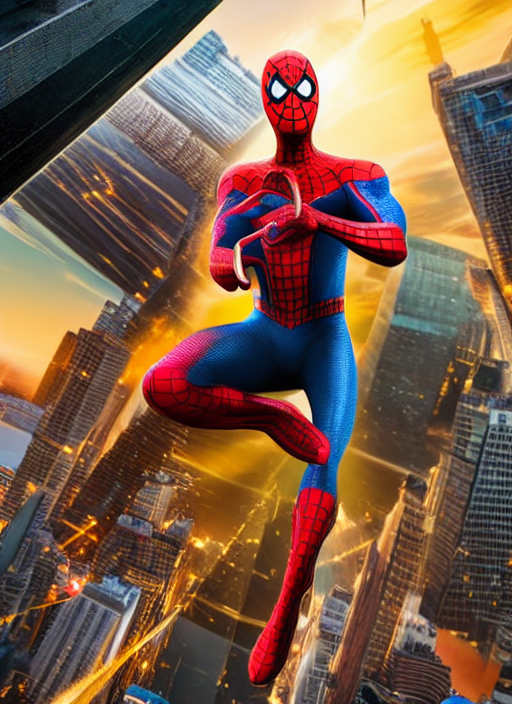

In [16]:
prompt = "spiderman, best quality, extremely detailed"
output = pipe(
    prompt,
    pose,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=20,
).images[0]
output

In [17]:
delete_pipeline(pipe)

## ControlNet HED (Scribble)

In [40]:
hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')

image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-scribble/resolve/main/images/bag.png")

image = hed(image, scribble=True)
image

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-66157904-0f63c6205708da9b2c0ad6c6;30a8f740-6c7c-4f44-be89-7f6663c0ca51)

Entry Not Found for url: https://huggingface.co/lllyasviel/ControlNet/resolve/main/ControlNetHED.pth.

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)



image = pipe("bag", image, num_inference_steps=20).images[0]


## ControlNet Depth

In [46]:
depth_estimator = pipeline('depth-estimation')

image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png")

image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

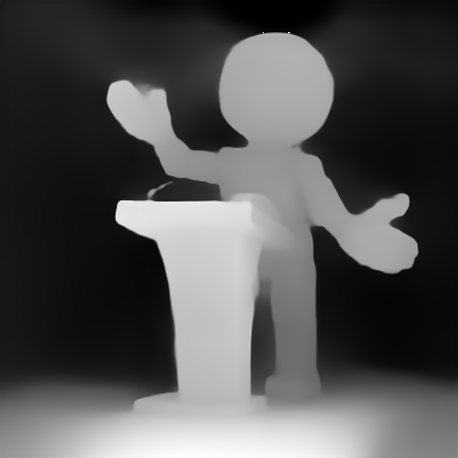

In [47]:
image

In [43]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)



pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

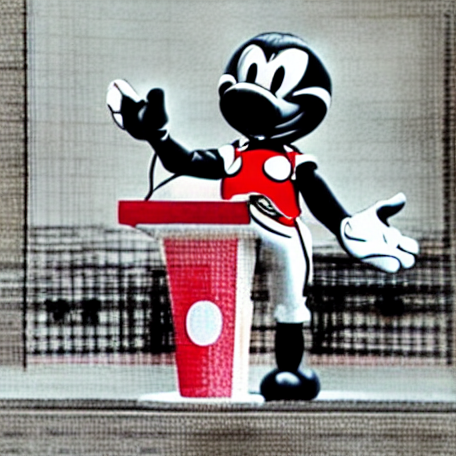

In [48]:
image = pipe("mickey mouse waving", image, num_inference_steps=20).images[0]
image

In [50]:
delete_pipeline(pipe)

## ControlNet Segmentation

In [49]:
palette = np.asarray([
    [0, 0, 0],
    [120, 120, 120],
    [180, 120, 120],
    [6, 230, 230],
    [80, 50, 50],
    [4, 200, 3],
    [120, 120, 80],
    [140, 140, 140],
    [204, 5, 255],
    [230, 230, 230],
    [4, 250, 7],
    [224, 5, 255],
    [235, 255, 7],
    [150, 5, 61],
    [120, 120, 70],
    [8, 255, 51],
    [255, 6, 82],
    [143, 255, 140],
    [204, 255, 4],
    [255, 51, 7],
    [204, 70, 3],
    [0, 102, 200],
    [61, 230, 250],
    [255, 6, 51],
    [11, 102, 255],
    [255, 7, 71],
    [255, 9, 224],
    [9, 7, 230],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [7, 255, 224],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [255, 122, 8],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
    [31, 255, 0],
    [255, 31, 0],
    [255, 224, 0],
    [153, 255, 0],
    [0, 0, 255],
    [255, 71, 0],
    [0, 235, 255],
    [0, 173, 255],
    [31, 0, 255],
    [11, 200, 200],
    [255, 82, 0],
    [0, 255, 245],
    [0, 61, 255],
    [0, 255, 112],
    [0, 255, 133],
    [255, 0, 0],
    [255, 163, 0],
    [255, 102, 0],
    [194, 255, 0],
    [0, 143, 255],
    [51, 255, 0],
    [0, 82, 255],
    [0, 255, 41],
    [0, 255, 173],
    [10, 0, 255],
    [173, 255, 0],
    [0, 255, 153],
    [255, 92, 0],
    [255, 0, 255],
    [255, 0, 245],
    [255, 0, 102],
    [255, 173, 0],
    [255, 0, 20],
    [255, 184, 184],
    [0, 31, 255],
    [0, 255, 61],
    [0, 71, 255],
    [255, 0, 204],
    [0, 255, 194],
    [0, 255, 82],
    [0, 10, 255],
    [0, 112, 255],
    [51, 0, 255],
    [0, 194, 255],
    [0, 122, 255],
    [0, 255, 163],
    [255, 153, 0],
    [0, 255, 10],
    [255, 112, 0],
    [143, 255, 0],
    [82, 0, 255],
    [163, 255, 0],
    [255, 235, 0],
    [8, 184, 170],
    [133, 0, 255],
    [0, 255, 92],
    [184, 0, 255],
    [255, 0, 31],
    [0, 184, 255],
    [0, 214, 255],
    [255, 0, 112],
    [92, 255, 0],
    [0, 224, 255],
    [112, 224, 255],
    [70, 184, 160],
    [163, 0, 255],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [255, 0, 143],
    [0, 255, 235],
    [133, 255, 0],
    [255, 0, 235],
    [245, 0, 255],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 41, 255],
    [0, 255, 204],
    [41, 0, 255],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [122, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [0, 133, 255],
    [255, 214, 0],
    [25, 194, 194],
    [102, 255, 0],
    [92, 0, 255],
])


In [52]:
image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")
image_segmentor = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small")

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [53]:
image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house.png").convert('RGB')

pixel_values = image_processor(image, return_tensors="pt").pixel_values

with torch.no_grad():
  outputs = image_segmentor(pixel_values)

seg = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_seg[seg == label, :] = color

color_seg = color_seg.astype(np.uint8)

image = Image.fromarray(color_seg)

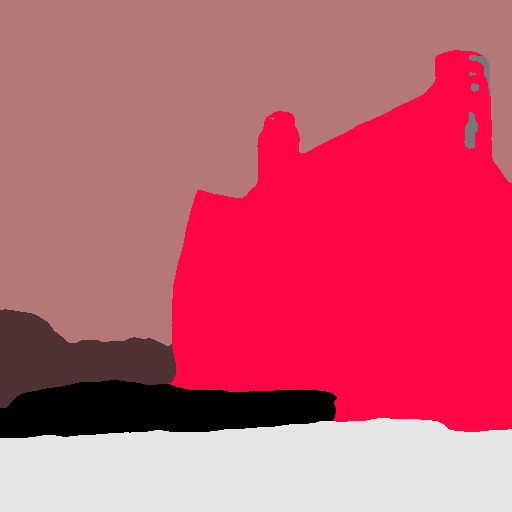

In [54]:
image

In [55]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

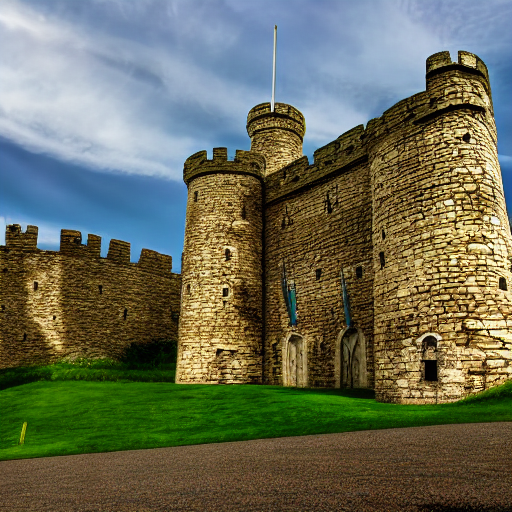

In [57]:
image = pipe("a castle", image, num_inference_steps=20).images[0]
image